# Case study in PyMC3: Coal mining disasters

## Takeaways from this notebook
1. Examine a model that showcases some of the flexibility of Bayesian modelling.
2. Get a sense of what's in a Variable object in PyMC3.
3. Learn to use the trace object that is a result of the MCMC sampling routines.
4. Refresh your memory regarding some common distributions we are likely to use in our work.

## Motivating Example: Coal mining disasters

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period.

Let's build a model for this series and attempt to estimate when the change occurred. First we plot the data and specify the form of the model mathematically and proceed to encoded it in PyMC3 and run inference.

### Notes on the model
The purpose of the model is to try and identify a discrete change in the rate of mining accidents. The model assumes that up to a certain year $\tau$ the rate was $\lambda_1$ while starting with $\tau$ the rate is $\lambda_2$. The prior on $\tau$ is a discrete uniform distribution, since all years are equally likely to be the swiching point. The priors on the rates $\lambda_i$ are exponential distributions.

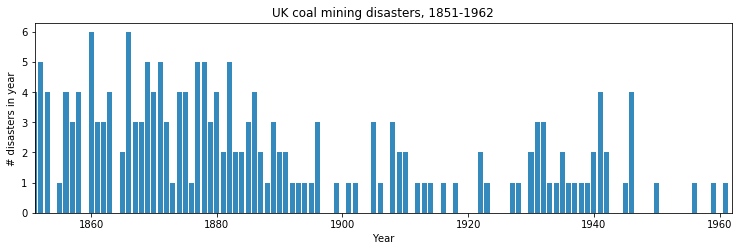

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

disasters_per_year_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

n_years = len(disasters_per_year_data)

plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_per_year_data, color="#348ABD")
plt.xlabel("Year")
plt.ylabel("# disasters in year")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962);

We represent our conceptual model formally as a statistical model, where we introduce shorthand notation in the table below.

$$\begin{array}{|c|l|l|}
\hline
\textbf{Quantity} & \textbf{Variable name} & \textbf{Description} \\
\hline
y_t & \text{disasters_per_year_data} & \text{number of disasters} \\
\hline
\lambda_1 & \text{early_mean} & \text{mean number of disasters per year for years before} 
\tau \text{, Poisson parameter} \\
\hline
\lambda_2 & \text{late_mean} & \text{mean number of disasters per year for years}  
\tau \text{and later, Poisson parameter} \\
\hline
\tau & \text{switchpoint} & \text{the year when the disaster rate makes a step change from } \lambda_1 \text{ to } \lambda_2 \\
\hline
r_t & \text{rate} & \text{the Poisson rate parameter for year } t \text{ set depending on actual year to } \lambda_1 \text{ or } \lambda_2 \\
\hline
t_l & \text{no variable, fixed at 0} & \text{points to first year in the dataset, 0-indexed} \\
\hline
t_h & \text{no variable, fixed at #years} & \text{points to last year in the dataset} \\
\hline
a & \text{no variable, fixed at 1} & \text{parameter of the exponential prior for } \lambda_1 \\
\hline
b & \text{no variable, fixed at 1} & \text{parameter of the exponential prior for } \lambda_2 \\
\hline
\end{array}
$$

**Note:** if you are not familiar with the Poisson and exponential distributions, there are exercises at the end of the notebook that should help.

Using the above notation, we now introduce the model formulation:

$$\begin{array}{ccc}
(y_t | \tau, \lambda_1, \lambda_2) \sim\text{Poisson}\left(r_t\right), & r_t=\left\{
\begin{array}{lll}             
\lambda_1 &\text{if}& t< \tau\\ 
\lambda_2 &\text{if}& t\ge \tau             
\end{array}\right.,&t\in[t_l,t_h]\\         
\tau \sim \text{DiscreteUniform}(t_l, t_h)\\         
\lambda_1\sim \text{Exponential}(a)\\         
\lambda_2\sim \text{Exponential}(b)     
\end{array}$$

Because we have defined $y$ by its dependence on $\tau$, $\lambda_1$ and $\lambda_2$, the latter three are known as the *parents* of $y$, and $y$ is called their *child*. Similarly, the parents of $\tau$ are $t_l$ and $t_h$, and $\tau$ is the child of $t_l$ and $t_h$.

## Implementing a PyMC Model

At the model-specification stage (before the data are observed), $y$, $\tau$, $\lambda_1$, and $\lambda_2$ are all random variables. Bayesian "random" variables have not necessarily arisen from a physical random process. The Bayesian interpretation of probability is **epistemic**, meaning random variable $x$'s probability distribution $p(x)$ represents our knowledge and uncertainty about $x$'s value. Candidate values of $x$ for which $p(x)$ is high are relatively more probable, given what we know. 

We can generally divide the variables in a Bayesian model into two types: **stochastic** and **deterministic**. The only deterministic variable in this model is $r$. If we know the values of $r$'s parents, we can compute the value of $r$ exactly. A deterministic like $r$ is defined by a mathematical function that returns its value given values for its parents. Deterministic variables are sometimes called the *systemic* part of the model. The nomenclature is a bit confusing, because these objects usually represent random variables; since the parents of $r$ are random, $r$ is random also.

On the other hand, even if the values of the parents of variables `switchpoint`, `disasters` (before observing the data), `early_mean` or `late_mean` were known, we would still be uncertain of their values. These variables are stochastic, characterized by probability distributions that express how plausible their candidate values are, given values for their parents.

Let's begin by defining the unknown switchpoint as a discrete uniform random variable. Please note that in contrast to the formal definition, we define `switchpoint` on the interval from `0` to `n_years` here. It makes the things easier for us regarding the indexing.

In [2]:
from pymc3 import DiscreteUniform, Model

with Model() as disaster_model:

    switchpoint = DiscreteUniform('switchpoint', lower=0, upper=n_years)

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We have done two things here. First, we have created a `Model` object; a `Model` is a Python object that encapsulates all of the variables that comprise our theoretical model, keeping them in a single container so that they may be used as a unit. After a `Model` is created, we can populate it with all of the model components that we specified when we wrote the model down. 

Notice that the `Model` above was declared using a `with` statement. This expression is used to define a Python idiom known as a **context manager**. Context managers, in general, are used to manage resources of some kind within a program. In this case, our resource is a `Model`, and we would like to add variables to it so that we can fit our statistical model. The key characteristic of the context manager is that the resources it manages are only defined within the indented block corresponding to the `with` statement. PyMC uses this idiom to automatically add defined variables to a model. Thus, any variable we define is automatically added to the `Model`, without having to explicitly add it. This avoids the repetitive syntax of `add` methods/functions that you see in some machine learning packages:

```python
model.add(a_variable)
model.add(another_variable)
model.add(yet_another_variable)
model.add(and_again)
model.add(please_kill_me_now)
...
```

In fact, PyMC variables cannot be defined without a corresponding `Model`:

In [3]:
# remove comment to show error
#oops = DiscreteUniform('oops', lower=0, upper=10)

However, variables can be explicitly added to models without the use of a context manager, via the variable's optional `model` argument.

```python
disaster_model = Model()
switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, model=disaster_model)
```

### Probability mass/density functions implemented in PyMC3

PyMC3 includes most of the common random variable **distributions** used for statistical modeling.

In [4]:
from pymc3 import distributions
distributions.__all__

['Uniform',
 'Flat',
 'HalfFlat',
 'Normal',
 'Beta',
 'Exponential',
 'Laplace',
 'StudentT',
 'Cauchy',
 'HalfCauchy',
 'Gamma',
 'Weibull',
 'Bound',
 'Lognormal',
 'HalfStudentT',
 'ChiSquared',
 'HalfNormal',
 'Wald',
 'Pareto',
 'InverseGamma',
 'ExGaussian',
 'VonMises',
 'Binomial',
 'BetaBinomial',
 'Bernoulli',
 'Poisson',
 'NegativeBinomial',
 'ConstantDist',
 'Constant',
 'ZeroInflatedPoisson',
 'ZeroInflatedNegativeBinomial',
 'ZeroInflatedBinomial',
 'DiscreteUniform',
 'Geometric',
 'Categorical',
 'DensityDist',
 'Distribution',
 'Continuous',
 'Discrete',
 'NoDistribution',
 'TensorType',
 'MvNormal',
 'MatrixNormal',
 'MvStudentT',
 'Dirichlet',
 'Multinomial',
 'Wishart',
 'WishartBartlett',
 'LKJCholeskyCov',
 'LKJCorr',
 'AR1',
 'AR',
 'GaussianRandomWalk',
 'MvGaussianRandomWalk',
 'MvStudentTRandomWalk',
 'GARCH11',
 'SkewNormal',
 'Mixture',
 'NormalMixture',
 'Triangular',
 'DiscreteWeibull',
 'Gumbel',
 'Logistic',
 'Interpolated',
 'Bound']

By having a library of variables that represent statistical distributions, users are relieved of having to code distrbutions themselves. 

Similarly, we can create the exponentially-distributed variables `early_mean` and `late_mean` for the early and late Poisson rates, respectively (also in the context of the model `distater_model`):

In [5]:
from pymc3 import Exponential

with disaster_model:
    
    early_mean = Exponential('early_mean', 1)
    late_mean = Exponential('late_mean', 1)

Next, we define the variable `rate`, which selects the early rate `early_mean` for times before `switchpoint` and the late rate `late_mean` for times after `switchpoint`. We create `rate` using the `switch` function, which returns `early_mean` when the switchpoint is larger than (or equal to) a particular year, and `late_mean` otherwise.

The `switch` function creates a _deterministic_ component `rate`, since there is no uncertainty in the value of `rate` given values of its parents. 

In [6]:
from pymc3.math import switch

with disaster_model:
    
    rate = switch(switchpoint >= np.arange(n_years), early_mean, late_mean)

The last step is to define the **data likelihood**, or sampling distribution. In this case, our measured outcome is the number of disasters in each year, `disasters`. This is a stochastic variable but unlike `early_mean` and `late_mean` we have *observed* its value. To express this, we set the argument `observed` to the observed sequence of disasters. This tells PyMC that this distribution's value is fixed, and should not be changed:

In [7]:
from pymc3 import Poisson

with disaster_model:
    
    disasters = Poisson('disasters', mu=rate, observed=disasters_per_year_data)

### Why are data and unknown variables represented by the same object?

Since its represented by PyMC random variable object, `disasters` is defined by its dependence on its parent `rate` even though its value is **fixed**. This isn't just a quirk of PyMC's syntax; Bayesian hierarchical notation itself makes no distinction between random variables and data. The reason is simple: to use Bayes' theorem to compute the posterior, we require the likelihood. Even though `disasters`'s value is known and fixed, we need to formally assign it a *probability distribution* as if it were a random variable. Remember, the likelihood and the probability function are essentially the same, except that the former is regarded as a function of the parameters and the latter as a function of the data. This point can be counterintuitive at first, as many peoples' instinct is to regard data as fixed a priori and unknown variables as dependent on the data. 

One way to understand this is to think of statistical models as predictive models for data, or as models of the processes that gave rise to data. Before observing the value of `disasters`, we could have sampled from its prior predictive distribution $p(y)$ (*i.e.* the marginal distribution of the data) as follows:

-   Sample `early_mean`, `switchpoint` and `late_mean` from their priors.
-   Sample `disasters` conditional on these values.

Even after we observe the value of `disasters`, we need to use this process model to make inferences about `early_mean` , `switchpoint` and `late_mean` because its the only information we have about how the variables are related.

We will see later that we can sample from this fixed stochastic random variable, to obtain predictions after having observed our data.

The model that we specified at the top of the page has now been fully implemented in PyMC3. Let's have a look at the model's attributes to see what we have.

The stochastic nodes in the model are identified in the `vars` (*i.e.* variables) attribute:

In [8]:
disaster_model.vars

[switchpoint, early_mean_log__, late_mean_log__]

The last two variables are the log-transformed versions of the early and late rate parameters. In PyMC3, variables with purely positive priors like `Exponential` are **transformed** with a log function. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named `<variable name>_log_`) is added to the model for sampling. In this model this happens behind the scenes. Variables with priors that constrain them on two sides, like `Beta` or `Uniform` (continuous), are also transformed to be unconstrained but with a log odds transform.

The original variables have become deterministic nodes in the model, since they only represent values that have been back-transformed from the transformed variable, which has been subject to fitting or sampling.

In [9]:
disaster_model.deterministics

[early_mean, late_mean]

You might wonder why `rate`, which is a deterministic component of the model, is not in this list. This is because, unlike the other components of the model, `rate` has not been given a name and given a formal PyMC data structure. It is essentially an **intermediate calculation** in the model, implying that we are not interested in its value when it comes to summarizing the output from the model. Most PyMC objects have a name assigned; these names are used for storage and post-processing:

-   as keys in on-disk databases,
-   as axis labels in plots of traces,
-   as table labels in summary statistics.

If we wish to include `rate` in our output, we need to make it a `Deterministic` object, and give it a name:

In [10]:
from pymc3 import Deterministic

with disaster_model:
    
    rate = Deterministic('rate', switch(switchpoint >= np.arange(n_years), early_mean, late_mean))

Now, `rate` is included in the `Model`'s deterministics list, and the model will retain its samples during MCMC sampling, for example.

In [11]:
disaster_model.deterministics

[early_mean, late_mean, rate]

## PyMC3 Variables

Each of the built-in statistical variables are subclasses of the generic `Distribution` class in PyMC3. The `Distribution` carries relevant **attributes** about the probability distribution, such as the data type (called `dtype`), any relevant transformations (`transform`, see below), and initial values (`init_value`).

In [12]:
disasters.dtype

'int64'

In [13]:
early_mean.init_value

array(0.69314718)

PyMC's built-in distribution variables can also be used to generate **random values** from that variable. For example, the `switchpoint`, which is a discrete uniform random variable, can generate random draws:

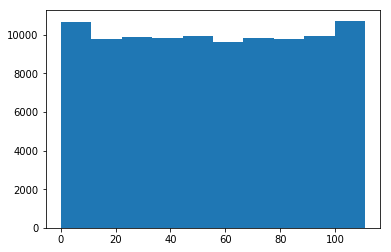

In [14]:
plt.hist(switchpoint.random(size=100000));

As we noted earlier, some variables have undergone **transformations** prior to sampling. Such variables will have `transformed` attributes that points to the variable that it has been transformed to.

In [15]:
early_mean.transformed

early_mean_log__

Variables will usually have an associated distribution, as determined by the constructor used to create it. For example, the `switchpoint` variable was created by calling `DiscreteUniform()`. Hence, its distribution is `DiscreteUniform`:

In [16]:
switchpoint.distribution

As with all Python objects, the underlying type of a variable can be exposed with the `type()` function:

In [17]:
type(switchpoint)

pymc3.model.FreeRV

In [18]:
type(disasters)

pymc3.model.ObservedRV

We will learn more about these types in a later section.

## Variable log-probabilities

All PyMC3 stochastic variables can evaluate their probability mass or density functions at a particular value, given the values of their parents. The **logarithm** of a stochastic object's probability mass or density can be
accessed via the `logp` method.

**Note**: the PyMC3 stochastic variables don't implement the probability mass/density function at all, only the logarithm as this is used for actual inference.

In [19]:
switchpoint.logp({'switchpoint':15, 'early_mean_log__':1, 'late_mean_log__':1})

array(-4.71849887)

For **vector-valued** variables like `disasters`, the `logp` attribute returns the **sum** of the logarithms of
the joint probability or density of all elements of the value.

In [20]:
disasters.logp({'switchpoint':55, 'early_mean_log__':1, 'late_mean_log__':1})

array(-225.5380749)

## Fitting the model with MCMC

PyMC3's `sample` function will fit probability models (linked collections of variables) like ours using Markov chain Monte Carlo (MCMC) sampling. Unless we manually assign particular algorithms to variables in our model, PyMC will assign algorithms that it deems appropriate (it usually does a decent job of this):

In [21]:
from pymc3 import sample
with disaster_model:
    trace = sample(2000, init=None, chains=1)

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_mean_log__, early_mean_log__]
 98%|█████████▊| 2449/2500 [00:02<00:00, 916.89it/s]/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 2500/2500 [00:02<00:00, 912.77it/s]
Tuning was enabled throughout the whole trace.
Only one chain was sampled, this makes it impossible to run some convergence checks


This returns the Markov chain of draws from the model in a data structure called a **trace**.

In [22]:
trace

<MultiTrace: 1 chains, 2000 iterations, 6 variables>

The `sample()` function always takes at least one argument, `draws`, which specifies how many samples to draw. However, there are a number of additional optional arguments that are worth knowing about:

In [23]:
help(sample)

Help on function sample in module pymc3.sampling:

sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, njobs=None, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=None, random_seed=None, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 500. The number of tuned
        samples are discarded by default. See discard_tuned_samples.
    step : function or iterable of functions
        A step function or collection of functions. If there are variables
        without a step methods, step methods for those variables will
        be assigned automatically.
    init : str
        Initialization method to use for auto-assig

The `step` argument is what allows users to manually override the sampling algorithms used to fit the model but we will not use this feature at this time.

### Accessing the samples

In [24]:
trace['late_mean']

array([0.77982398, 0.89771997, 1.10425853, ..., 0.71785406, 0.86173601,
       0.95682144])

The trace can also be sliced using the NumPy array slice `[start:stop:step]`. 

In [25]:
trace['late_mean', -5:]

array([0.80134876, 0.80134876, 0.71785406, 0.86173601, 0.95682144])

In [26]:
trace['late_mean', ::10]

array([0.77982398, 0.80924027, 0.96316573, 0.79583727, 0.90721797,
       1.08392005, 0.91260931, 0.73187845, 0.95129041, 0.96661917,
       0.94865327, 0.93184199, 1.18828956, 0.87981392, 1.04084578,
       0.90059728, 0.93272229, 0.99302876, 0.77909232, 0.79000238,
       1.01255645, 0.8559684 , 0.8831894 , 1.24239165, 0.86279176,
       1.03195316, 0.98655054, 0.98589579, 0.94077525, 0.8580929 ,
       0.89122111, 0.77161025, 0.92256387, 1.10698844, 0.89113032,
       0.87145864, 1.06491729, 1.05807624, 0.94900513, 1.11166521,
       1.06092149, 0.7216257 , 0.90793362, 1.15510918, 0.83192717,
       1.13588113, 0.98416566, 0.79674742, 0.94802993, 0.91124414,
       0.9940369 , 0.90962018, 0.99004663, 0.83234295, 1.04971452,
       0.91077038, 0.98085278, 0.84454246, 0.88460875, 0.83347529,
       1.10537067, 0.83229975, 0.8941254 , 1.01174907, 1.05556872,
       1.03997041, 0.89435955, 0.98572385, 0.88448373, 0.8722023 ,
       0.91566006, 0.84911748, 0.94909513, 0.87971522, 0.87100

### Sampling output

You can examine the marginal posterior of any variable by plotting a
histogram of its trace:

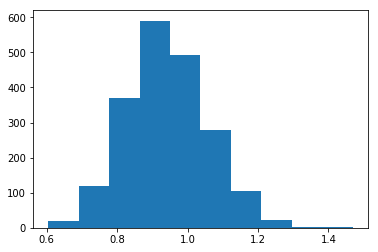

In [27]:
plt.hist(trace['late_mean']);

PyMC has its own plotting functionality dedicated to plotting MCMC output. For example, we can obtain a time series plot of the trace and a histogram using `traceplot`:

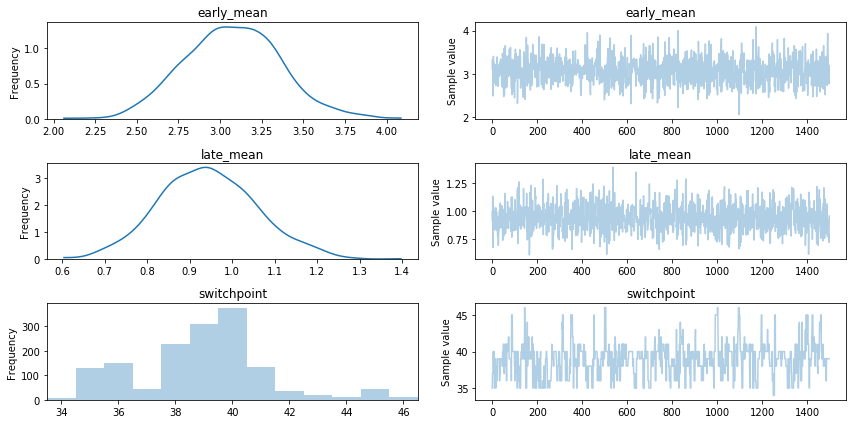

In [28]:
from pymc3 import traceplot

traceplot(trace[500:], varnames=['early_mean', 'late_mean', 'switchpoint']);

The upper left-hand pane of each figure shows the temporal series of the
samples from each parameter, while below is an autocorrelation plot of
the samples. The right-hand pane shows a histogram of the trace. The
trace is useful for evaluating and diagnosing the algorithm's
performance, while the histogram is useful for
visualizing the posterior.

For a non-graphical summary of the posterior, simply call the `summary` method.

In [29]:
from pymc3 import summary

summary(trace[500:], varnames=['early_mean', 'late_mean'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
early_mean,3.073345,0.286594,0.008802,2.492022,3.603441
late_mean,0.941716,0.115278,0.003652,0.715588,1.170567


## Exercise
Here we have more detail about the sample function and we have observed its output in detail. Important parameters for us now are **draws** and **tune**, which affect how many samples are drawn and how long the chain runs before beginning sampling.

- Note that the model contains a switchpoint variable and is not end-to-end differentiable.
- Play around with the parameters (hint: reduce both draws, tune) and re-run the cells above.
- Observe warnings emitted by the internal diagnostics of PyMC3.
- Observe how the output changes when you sample more/less.
- Get a feel for the variability in this model.
- No need to dig deeper into this or try to study details - we will do that later.

# Revisiting probability distributions
Let us revisit the list of distributions above and examine some of them in more detail.


In [30]:
distributions.__all__

['Uniform',
 'Flat',
 'HalfFlat',
 'Normal',
 'Beta',
 'Exponential',
 'Laplace',
 'StudentT',
 'Cauchy',
 'HalfCauchy',
 'Gamma',
 'Weibull',
 'Bound',
 'Lognormal',
 'HalfStudentT',
 'ChiSquared',
 'HalfNormal',
 'Wald',
 'Pareto',
 'InverseGamma',
 'ExGaussian',
 'VonMises',
 'Binomial',
 'BetaBinomial',
 'Bernoulli',
 'Poisson',
 'NegativeBinomial',
 'ConstantDist',
 'Constant',
 'ZeroInflatedPoisson',
 'ZeroInflatedNegativeBinomial',
 'ZeroInflatedBinomial',
 'DiscreteUniform',
 'Geometric',
 'Categorical',
 'DensityDist',
 'Distribution',
 'Continuous',
 'Discrete',
 'NoDistribution',
 'TensorType',
 'MvNormal',
 'MatrixNormal',
 'MvStudentT',
 'Dirichlet',
 'Multinomial',
 'Wishart',
 'WishartBartlett',
 'LKJCholeskyCov',
 'LKJCorr',
 'AR1',
 'AR',
 'GaussianRandomWalk',
 'MvGaussianRandomWalk',
 'MvStudentTRandomWalk',
 'GARCH11',
 'SkewNormal',
 'Mixture',
 'NormalMixture',
 'Triangular',
 'DiscreteWeibull',
 'Gumbel',
 'Logistic',
 'Interpolated',
 'Bound']

## Important distributions
Please make sure you're familiar with the form and parameters of the following distributions:
- Uniform
- Normal
- Exponential
- Poisson
- Beta
- Binomial
- Bernoulli
- NegativeBinomial
- Multinomial
- Gamma
- StudentT

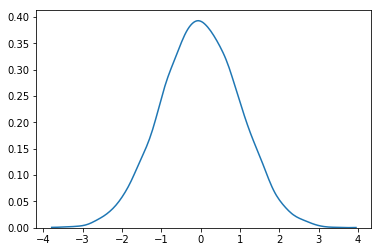

In [31]:
# Sample from a given distribution (without using a model)
# http://docs.pymc.io/prob_dists.html#using-pymc-distributions-without-a-model
from pymc3 import plots, Normal
y = Normal.dist(mu=0, sd=1)
plots.kdeplot(y.random(size=10000))

### Using scipy.stats to plot distributions and histograms

PyMC3 offers support for these distributions but you will find it's heavily geared toward inference.  For example there is no density function (continuous) and no probability mass function (discrete), just the log-probability.  Below is an example for the normal distribution - observe that the KDE (=kernel density estimate) plot is not especially accurate.

Therefore to investige the distributions, you may find it easier to use [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) as shown below the examples using pymc3.

However, if you are running short on time, it's fine to look at wikipedia to get acquainted.

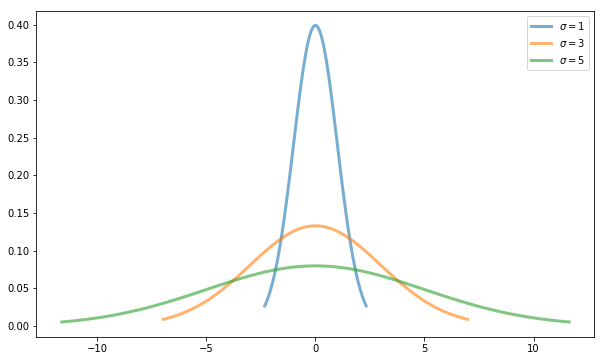

In [32]:
# taken from here: https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html
# NOTE: check scipy stats documentation for the meaning of the parameters passed to distributions. For example,
# in the Normal distribution, `loc` is the mean value and `sd` is the standard deviation.
# 
from scipy.stats import norm
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
#fit, ax = plt.subplots(1, 1)
legend = []
for sigma in [1, 3, 5]:
    x = np.linspace(norm.ppf(0.01,scale=sigma), norm.ppf(0.99,scale=sigma), 100)
    ax.plot(x, norm.pdf(x,scale=sigma), lw=3, alpha=0.6, label='norm pdf')
    legend.append('$\sigma = %g$' % sigma)
plt.legend(legend)
plt.show()

### Discrete example: binomial

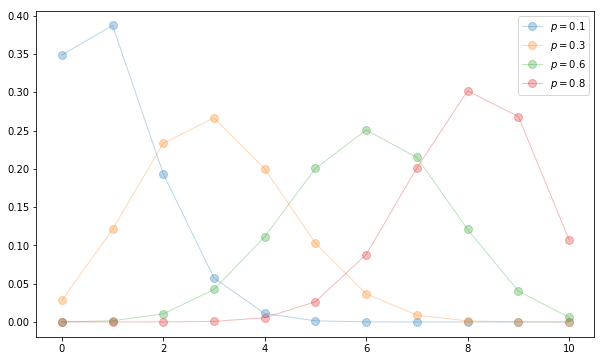

In [33]:
from scipy.stats import binom
import matplotlib.pyplot as plt

n = 10 # our choice of number of tries for the binomial distribution
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
x = range(11) # we know the universe of possible values is 0..10

legend = []
for p in [0.1, 0.3, 0.6, 0.8]:
    ax.plot(x, binom.pmf(x, n=n, p=p), 'o-', markersize=8, lw=1, alpha=0.3, label='norm pdf')
    r = binom.rvs(n=n, p=p, size=1000)
    legend.append('$p=%g$' % p)
plt.legend(legend)
plt.show()

## Exercise
Recreate the above plots with more distributions from the selected set above to get a feel for them.  Alternatively, look up the distributions on Wikipedia, which shows such graphs for many distributions.

## References

1. Salvatier, J., Wiecki, T. V., & Fonnesbeck, C. (2016). Probabilistic programming in Python using PyMC3. PeerJ Computer Science, 2(2), e55. http://doi.org/10.7717/peerj-cs.55
2. Getting started with PyMC3 (Apache License). http://docs.pymc.io/notebooks/getting_started.html